In [1]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Pkg
using IJulia
using Distributions
using Plots

In [2]:
include("../Test Models/COVIDResourceAllocation.jl")
using .COVIDResourceAllocation

normal setup (nurses_days_per_patient_day_covid)

In [3]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 36

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 5.142857142857143
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 4.666666666666666
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.8666666666666665


In [443]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 5, 22)
travel_threshold_hours = 8.0

adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours)

# Hospitalized_days are estimated using a Weibull distribution 

hospitalized_days = ceil(mean(Weibull(1.38,12.88)));

In [444]:
N = length(states);
T = (end_date - start_date).value + 1


forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_admitted = forecast(
    states, start_date,  end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)

forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)

forecast_discharged = forecast(
    states, start_date-Dates.Day(hospitalized_days), end_date-Dates.Day(hospitalized_days),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);
#forecast_discharged = hcat(forecast_discharged, zeros(Float32, N, T - hospitalized_days));

In [445]:
#start = (start_date - Date(2020, 3, 4)).value + 1
L = 1.0 .- cdf.(Weibull(1.38,12.88), 0:T)

net_patients_per_day = [(
    forecast_initial[i]
	- forecast_discharged[i,t]
	+ sum(L[t-t₁+1]forecast_admitted[i,t₁] for t₁ in 1:t)
	) for i in 1:N, t in 1:T
]
demand = net_patients_per_day[:,1:T]*nurse_days_per_patient_day_covid

11×80 Matrix{Float64}:
 0.0     0.0      0.0      0.0      0.0      …   3941.59      3798.15
 0.0     0.0      0.0      0.0      0.0           563.64       547.746
 0.0     0.0      0.0      0.0      3.88752      4287.34      4151.55
 0.0     0.0      0.0      0.0      0.0          4710.57      4649.61
 0.0     0.0      0.0      0.0      0.0            86.9813      86.9124
 0.0     0.0      0.0      0.0      0.0      …    515.695      518.598
 0.0     0.0      0.0      0.0      0.0         10782.6      10404.5
 5.124  10.3238  15.1202  24.7934  39.0275      10305.6       9831.83
 0.0     0.0      0.0      0.0      0.0          7054.51      6866.58
 0.0     0.0      0.0      0.0      0.0          1101.09      1095.96
 0.0     0.0      0.0      0.0      0.0      …      8.58406      7.45943

In [438]:
initial_demand = demand;

This chunk is made to adjust the nurses-patients ratio

In [67]:
# pct_nurses_available = 0.5
# patients_per_nurse_covid = 2.5
# nurse_hrs_per_week_covid = 48

# @show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
# @show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

# @show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

In [446]:
nurses = n_nurses(states) * Float32(pct_nurses_available);

(DONT NEED TO DO THIS NOW)Plot the forecasted active patients over time by state to better choose the length of time for isolation

In [69]:
# start_date_new = Date(2020, 3, 30)
# end_date_new   = Date(2020, 5, 1)
# date_range = start_date_new:end_date_new
# states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
# states_cleaned = [replace(state, r"[, ]" => "") for state in states]
# states_cleaned_row = hcat(states_cleaned...)

# # # check the shortage matrix
# # # size(shortage_matrix)
# start = (start_date_new - start_date).value+1
# t_length = (end_date_new - start_date_new).value
# df = forecast_active[:,start:start+t_length]

# plot(date_range,[vec(df[i,:]) for i in 1:size(df)[1]],
#      xlabel = "Date",
#      ylabel = "Forecasted Active Patients By State",
#      title = "Forecasted Active Patients over Time",
#      legend = :topright,
#      label = states_cleaned_row,
#      linewidth = 2,
#      fmt=:png)

# #savefig(joinpath("../figures", "Forecasted_Active_Patients_Overtime.png"))


Always run this chunk to initialize all the following tables first before running the model!! 

MODEL!!!

From the historical shortage plot, we found that 2020.03.27 is the start date of shortage. Past work has estimated that starting to take precautionary steps 31-52 days ahead can help alleviate the patient overflow at most. However, we noticed that the first case happened on 3/4, which is 23 days ahead of the first shortage. Realistically, it's impossible to start taking action during zero cases period. Therefore, we decided to start transfer from that day. 

2020.03.04 - 2020.04.10 (14 days after the first shortage)

Contaminated hospitals: NY & NJ

2020.04.11 - 2020.04.24

Contaminated hospitals: CT & NY & NJ & MA

2020.04.25 - 2020.05.08

Contaminated hospitals: NJ & NY & CT

2020.05.09 - 2020.05.22

Contaminated hospitals: PA & CT & MA & MD



In [449]:
## create arrays to store all the model output
# total amount

start_date = Date(2020, 3, 4)
end_date   = Date(2020, 4, 10)
T = (end_date - start_date).value + 1

nurses_sent_tot = zeros(T)
shortage_tot = zeros(T)
# average_load = zeros(T)
patients_sent_tot = zeros(T)
# overall_shortage = zeros(T)

summary_model = DataFrame(
        state = states,
        total_sent = 0,
        total_received = 0,
        initial_nurses = 0,
        total_nurse_days = 0,
        total_demand = 0,
        total_shortage = 0)
complete_model = DataFrame(
        state = Any[],
        date = Any[],
        sent = Any[], 
        received = Any[],
        current_nurses = Any[],
        demand = Any[],
        shortage = Any[])
complete_modelp = DataFrame(
        location = Any[],
        date = Any[],
        sent = Any[]);
       

In [71]:
#["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]

In [450]:
contaminated_hospitals = vec([0,0,0,0,0,0,1,1,0,0,0])

stage1_matrix = copy(adj)

        for i in 1:N  
            for j in 1:N 
                # check that the edge is directed toward the contaminated hospital
                # if true set the matrix idx to 1 else leave it as 0 
                stage1_matrix[i,j] = (contaminated_hospitals[j] == 1)
            end
        end
        
    stage2_matrix = copy(adj)
    for i in 1:N  
        for j in 1:N 
            if contaminated_hospitals[i] == 1 || contaminated_hospitals[j] == 1
                stage2_matrix[i,j] = 0
            end
        end
    end

start = ceil(((start_date - Date(2020, 3, 4)).value)/2) + 1

# demand = forecast_active[:,start:start + T - 1] * nurse_days_per_patient_day_covid

for t in Int(start):Int(start + ceil(T/2) - 1)
    #indices = findall(x -> x == 1, contaminated_hospitals)

    model1 = reusable_resource_allocation(
        nurses,
        zeros(Float32, size(demand[:, 2*t-1:2*t])...),
        demand[:, 2*t-1:2*t],
        stage1_matrix,
        obj_dir = :shortage,  
        send_new_only = false,
        sendrecieve_switch_time = 0,
        min_send_amt = 0,
        smoothness_penalty = 0,
        setup_cost = 0,
        sent_penalty = 0.01,
        verbose = true
    );

    sent_nurses_contam = value.(model1[:sent])
    #indices = findall(x -> x == 1, contaminated_hospitals)
    received_by_contaminated = [sum(sent_nurses_contam[:, j, :]) for j in 1:length(contaminated_hospitals)]
    sent_to_contaminated = [sum(sent_nurses_contam[j, :, :]) for j in 1:length(contaminated_hospitals)]
    nurses_afterstage1 = nurses-sent_to_contaminated+received_by_contaminated

    model1_result = NurseAllocationResults.results_all(sent_nurses_contam, nurses, demand[:, 2*t-1:2*t], states, start_date)
    # stage1_shortage_tot = model1_result.total_shortage
    # stage1_average_load = model1_result.average_load
    summary1 = model1_result.summary_table

    #nurses_sent_tot[t] = sum(sent_nurses_contam)
    forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
    )[:]

    
    model2 = patient_nurse_allocation(
        forecast_initial,#demand[:, t:t+1],#nurses_afterstage1, 
        forecast_discharged[:, 2*t-1:2*t],
        forecast_admitted[:, 2*t-1:2*t],
        nurses_afterstage1,
        stage2_matrix,
        smoothness_penalty = 0.01,
        los=Weibull(1.38,12.88),
        nurse_days_per_patient_day = nurse_days_per_patient_day_covid,
        verbose =false
    );

    sent_nurses_uncontam = value.(model2[:sentnurses])
    sent_patients_uncontam = value.(model2[:sentpatients])
    #indices = findall(x -> x == 0, contaminated_hospitals)
    receivedn_by_uncontaminated = [sum(sent_nurses_uncontam[:, j, :]) for j in 1:length(contaminated_hospitals)]
    sentn_to_uncontaminated = [sum(sent_nurses_uncontam[j, :, :]) for j in 1:length(contaminated_hospitals)]
    receivedp_by_uncontaminated = [sum(sent_patients_uncontam[:, j, :]) for j in 1:length(contaminated_hospitals)]
    sentp_to_uncontaminated = [sum(sent_patients_uncontam[j, :, :]) for j in 1:length(contaminated_hospitals)]

    nurses = nurses_afterstage1-sentn_to_uncontaminated+receivedn_by_uncontaminated
    demand[:,t+1] .+= (receivedp_by_uncontaminated - sentp_to_uncontaminated) *  nurse_days_per_patient_day_covid

    # nurses_sent_tot[t] += sum(sent_nurses_uncontam)
    # patients_sent_tot[t] = sum(sent_patients_uncontam)

    model2_presult = PatientAllocationResults.results_all(sent_patients_uncontam, nurses_afterstage1, forecast_initial, forecast_admitted[:, 2*t-1:2*t], forecast_discharged[:, 2*t-1:2*t], states, start_date, Weibull(1.38,12.88));
    model2_nresult = NurseAllocationResults.results_all(sent_nurses_uncontam, nurses_afterstage1, demand[:,2*t-1:2*t], states, start_date)

    summary2 = model2_nresult.summary_table
    
    summary_model.total_sent += summary1.total_sent + summary2.total_sent
    summary_model.total_received += summary1.total_received + summary2.total_received
    summary_model.initial_nurses = summary2.initial_nurses
    summary_model.total_nurse_days = summary2.total_nurse_days
    summary_model.total_demand += summary2.total_demand
    summary_model.total_shortage += summary2.total_shortage
    #summary_model.average_load = (summary1.average_load * nurses_afterstage1 + summary2.average_load * nurses)/2
    
    complete1 = model1_result.complete_table[:,["state","date","sent", "received","current_nurses","demand","shortage"]]
    complete2 = model2_nresult.complete_table[:,["state","date","sent", "received","current_nurses","demand","shortage"]]
    complete2p = model2_presult.complete_table[:,["location","date","sent"]]

    sent_byTime = complete1.sent + complete2.sent 
    received_byTime = complete1.received + complete2.received
    #demand_byTime = complete2.demand
    #shortage_byTime = complete2.shortage
    
    complete_currentstage = copy(complete2)
    complete_currentstage.sent = sent_byTime
    complete_currentstage.received = received_byTime

    if isempty(complete_model)
        complete_model = copy(complete_currentstage)
    else
        complete_model = vcat(complete_model, complete_currentstage)
    end

    complete_currentstage_p = copy(complete2p)
    complete_currentstage_p.sent = complete2p.sent
    
    if isempty(complete_modelp)
        complete_modelp = copy(complete_currentstage_p)
    else
        complete_modelp = vcat(complete_modelp, complete_currentstage_p)
    end


    # stage2_shortage_tot = model2_nresult.total_shortage
    # stage2_average_load = model2_nresult.average_load 

    # overall_shortage[t] = stage2_shortage_tot
    # average_load[t] = stage2_average_load
    
    start_date = start_date + Dates.Day(2)

    t = t + 2
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 22.6.0 22G513)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 385 rows, 264 columns and 1386 nonzeros
Model fingerprint: 0x13b483df
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+02, 1e+04]
Presolve removed 385 rows and 264 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  0.000000000e+00

User-callback calls 34, time in user-callback 0.00 sec
Set parameter Username
Academic license - for non-commercial u

In [451]:
summary_model

Row,state,total_sent,total_received,initial_nurses,total_nurse_days,total_demand,total_shortage
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,CT,4136.07,1941.66,204.194,784.19,30409.7,18845.7
2,DE,1177.92,708.581,71.354,227.339,2052.75,642.123
3,MA,6531.74,2309.99,1702.49,1702.49,21779.5,7612.12
4,MD,3708.34,1449.35,1651.01,1651.01,19240.4,4931.71
5,ME,1307.62,332.407,11.5707,101.091,1251.35,727.696
6,NH,1356.78,394.599,9.63863,85.8119,1313.15,698.27
7,NJ,752.485,2272.84,4846.36,9692.71,1.25718e5,51989.5
8,NY,0.0,15733.9,25507.4,51014.8,479216.0,100610.0
9,PA,7323.07,2075.11,132.714,2818.24,27495.1,14563.2


In [453]:
complete_model

Row,state,date,sent,received,current_nurses,demand,shortage
,String,Date,Float64,Float64,Float64,Float64,Float64
1,CT,2020-03-04,0.0,0.0,2296.5,0.0,0.0
2,CT,2020-03-05,0.0,0.0,2296.5,0.0,0.0
3,DE,2020-03-04,0.0,0.0,661.0,0.0,0.0
4,DE,2020-03-05,0.0,0.0,661.0,0.0,0.0
5,MA,2020-03-04,0.0,0.0,5073.0,0.0,0.0
6,MA,2020-03-05,0.0,0.0,5073.0,0.0,0.0
7,MD,2020-03-04,0.0,0.0,3084.5,0.0,0.0
8,MD,2020-03-05,0.0,0.0,3084.5,0.0,0.0
9,ME,2020-03-04,0.0,0.0,981.0,0.0,0.0


In [456]:
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 4, 10)

date_range = start_date:end_date
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)
df = complete_model
cleaned_df = DataFrame(State=df.state, Date=df.date, Shortage=df.shortage)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
shortage_matrix = zeros(11, T)
for (i, state_df) in enumerate(grouped_df)
    shortage_matrix[i, :] .= state_df.Shortage
end

# # check the shortage matrix
# # size(shortage_matrix)

plot(date_range,[vec(shortage_matrix[i,:]) for i in 1:size(shortage_matrix)[1]],
     xlabel = "Date",
     ylabel = "Shortage By State",
     title = "Shortage over Time",
     legend = :topleft,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)

# remember to include the time frame in the file name
savefig(joinpath("../figures", "Contagion_shortage_plot-304-410.png"))


"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/Contagion_shortage_plot-304-410.png"

This cell is to keep the shortage over time by state

In [416]:
shortage_matrix_4 = hcat(shortage_matrix_3,shortage_matrix)

11×80 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  3987.8     3475.09     3331.65
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      177.702    168.003     152.172
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     3575.05    3443.4      3307.61
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2901.17    1411.99     1351.02
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       33.6658    33.4092     33.2759
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   172.144    175.21      178.113
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       16.0582     0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      414.3      415.637     410.509
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …     7.7145     6.43954     5.31491

In [478]:
df = DataFrame(permutedims(shortage_matrix_4), :auto)

# Add column names
columns = ["Column_$i" for i in 1:length(states)]
rename!(df, states)

show(df, allcols=true)

80×11 DataFrame
 Row │ CT       DE       MA       MD       ME       NH       NJ         NY        PA        RI       VT       
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64    Float64   Float64   Float64  Float64  
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │    0.0     0.0       0.0      0.0    0.0       0.0       0.0        0.0       0.0      0.0     0.0
   2 │    0.0     0.0       0.0      0.0    0.0       0.0       0.0        0.0       0.0      0.0     0.0
   3 │    0.0     0.0       0.0      0.0    0.0       0.0       0.0        0.0       0.0      0.0     0.0
   4 │    0.0     0.0       0.0      0.0    0.0       0.0       0.0        0.0       0.0      0.0     0.0
   5 │    0.0     0.0       0.0      0.0    0.0       0.0       0.0        0.0       0.0      0.0     0.0
   6 │    0.0     0.0       0.0      0.0    0.0       0.0       0.0        0.0       0.0      0.0     0.0
   7 │    0.0  

In [480]:
using Statistics
describe(df)
using CSV
CSV.write("../data output/DSContagShortage.csv",describe(df))

"../data output/DSContagShortage.csv"

In [407]:
shortage_matrix_3 = hcat(shortage_matrix2,shortage_matrix)

11×66 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  6023.19    5890.84    5754.72
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      604.61     572.975    610.468
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     5381.92    5279.0     5170.13
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     4715.87    4696.57    4663.61
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       96.7202    91.7418    94.1393
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   350.598    397.779    410.315
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     8915.51    6502.79    6103.34
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0        0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     6947.28    6896.18    6799.36
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1029.5     1040.11    1048.88
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    46.978     41.2289    36.6294

In [362]:
shortage_matrix_1 = shortage_matrix


11×38 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   3004.87     2857.76     3770.32
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       127.764     171.268      36.0625
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       600.563    1728.9      2020.68
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       504.509    1594.36     1857.45
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       111.393      34.1463    129.455
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    116.002      51.2743    134.074
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      7731.05     8716.73     9650.09
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     15840.0     17234.1     18288.1
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      2786.14     2273.3      1726.93
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       283.486      82.2173    403.501
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …     72.0432     72.6612     73.1999

In [397]:
shortage_matrix2 = hcat(shortage_matrix_1,shortage_matrix)

11×52 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   6563.68     6642.01     6698.85
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       434.919     451.858     465.973
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      5210.81     5365.03     5490.9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      3805.97     3891.99     3960.11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        90.7138     85.8097    102.627
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    239.284     257.542     239.194
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     15272.3     15283.1     15251.5
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     12308.3     11103.6      9867.86
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      6218.7      6377.1      6599.93
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       657.28      769.712     784.899
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …     76.0916     67.6676     77.751

Now we can plot the shortage over time by state

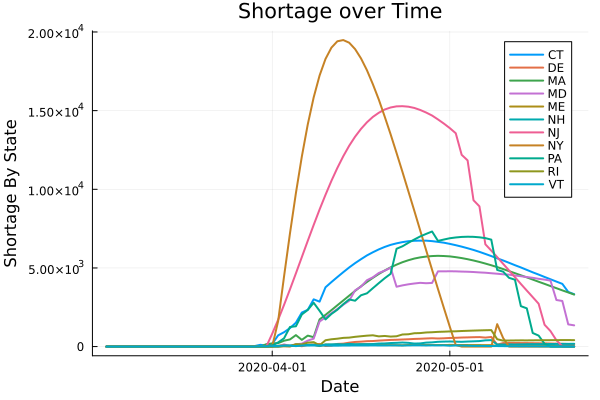

In [482]:
start_date = Date(2020, 3, 04)
end_date   = Date(2020, 5, 22)

date_range = start_date:end_date

states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

plot(date_range,[vec(shortage_matrix_4[i,:]) for i in 1:size(shortage_matrix_4)[1]],
     xlabel = "Date",
     ylabel = "Shortage By State",
     title = "Shortage over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)

# remember to include the time frame in the file name
#savefig(joinpath("../figures", "304-522_Contagion_shortage_plot.png"))


In [432]:
cumulative_shortage = vec(sum(shortage_matrix_4,dims = 1))

80-element Vector{Float64}:
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     ⋮
 24724.651126793535
 23847.41252035471
 21410.912746875445
 20517.024876561303
 18195.61341028657
 17255.146304395006
 15063.897071273868
 14127.528986147046
 12023.832212456291
 11285.599749761153
  9129.17483107657
  8769.666919174193

In [487]:
net_shortage = DataFrame(date = date_range, shortage = cumulative_shortage)
describe(net_shortage.shortage)

Summary Stats:
Length:         80
Missing Count:  0
Mean:           21231.949087
Std. Deviation: 19815.725835
Minimum:        0.000000
1st Quartile:   0.000000
Median:         18369.982599
3rd Quartile:   41032.548877
Maximum:        51493.836444
Type:           Float64


In [490]:
# Summary statistics
length_val = 80
Mean = 21231.949087
Std_Deviation = 19815.725835
Minimum = 0.000000
first_Quartile = 0.000000
Median = 18369.982599
third_Quartile = 41032.548877
Maximum = 51493.836444


# Create DataFrame
df_summary_overallshortage = DataFrame(
    Statistic = ["Length", "Mean", "Std. Deviation", "Minimum", "1st Quartile", "Median", "3rd Quartile", "Maximum"],
    Value = [length_val, Mean, Std_Deviation, Minimum, first_Quartile, Median, third_Quartile, Maximum]
)

# Show DataFrame
show(df_summary_overallshortage, allrows=true)

using CSV
CSV.write("../data output/DSOverallContagShortage.csv",df_summary_overallshortage)


8×2 DataFrame
 Row │ Statistic       Value   
     │ String          Float64 
─────┼─────────────────────────
   1 │ Length             80.0
   2 │ Mean            21231.9
   3 │ Std. Deviation  19815.7
   4 │ Minimum             0.0
   5 │ 1st Quartile        0.0
   6 │ Median          18370.0
   7 │ 3rd Quartile    41032.5
   8 │ Maximum         51493.8

"../data output/DSOverallContagShortage.csv"

In [433]:
net_shortage = DataFrame(date = date_range, shortage = cumulative_shortage)
using CSV
CSV.write("../data output/ContagShortage304-522.csv",net_shortage)

"../data output/ContagShortage304-522.csv"

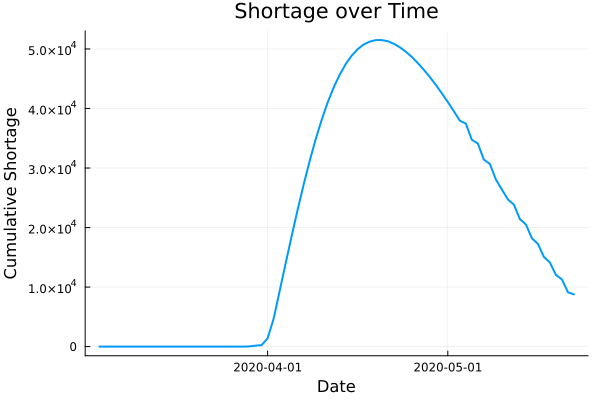

In [434]:
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 5, 22)
date_range = start_date:end_date
#gr()
plot(date_range, cumulative_shortage,
     xlabel = "Date",
     ylabel = "Cumulative Shortage",
     title = "Shortage over Time",
     legend = false,
     linewidth = 2,fmt=:png) 
#savefig(joinpath("../figures", "Overall_shortage_plot_Contagion.png"))    

# Try to smooth the curve by combining the date with a step size of 2 days

In [ ]:
# combined_dates = start_date:Day(2):end_date

# # Create a DataFrame with combined dates
# cleaned_df = DataFrame(State = String[], Date = Date[], Sent = Float64[])

# # Iterate over unique states
# for state_df in groupby(df, :state)
#     state = state_df[1, :state]
#     for date in combined_dates
#         next_two_days = date:Day(-1):date + Day(1)
#         sent = sum(state_df[state_df.date .∈ next_two_days, :sent])
#         push!(cleaned_df, (state, date, sent))
#     end
# end

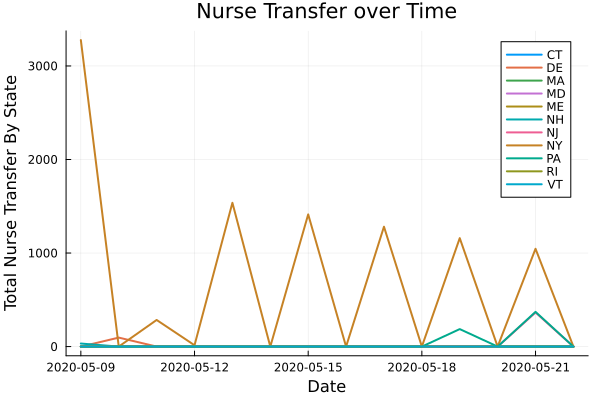

attempt to save state beyond implementation limit


In [422]:
start_date = Date(2020, 5, 9)
end_date   = Date(2020, 5, 22)
date_range = start_date:end_date
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)
df = complete_model

cleaned_df = DataFrame(State=df.state, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11xt matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, T)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# # check the shortage matrix
# # size(shortage_matrix)

plot(date_range,[vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Total Nurse Transfer By State",
     title = "Nurse Transfer over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)

#savefig(joinpath("../figures", "Contagion_NTransfer_plot304-410.png"))


nurses_sent over time by state

In [423]:
sent_matrix4 = hcat(sent_matrix3, sent_matrix)

11×80 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0           0.0    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0445686     0.0    0.0643431
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0           0.0    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0           0.0    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0           0.0    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0           0.0    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         364.407  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        1045.73   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         371.166  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0           0.0    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0           0.0    0.0

In [425]:
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 5, 22)

date_range = start_date:end_date

states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

plot(date_range,[vec(sent_matrix4[i,:]) for i in 1:size(sent_matrix4)[1]],
     xlabel = "Date",
     ylabel = "Nurse Transfer By State",
     title = "Nurse Transfer over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)

# remember to include the time frame in the file name
savefig(joinpath("../figures", "304-522_Contagion_NTransfer_plot.png"))


"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/304-522_Contagion_NTransfer_plot.png"

In [409]:
sent_matrix3 = hcat(sent_matrix2,sent_matrix)

11×66 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         3.9991    32.1828
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.682847   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.338232   3.82999
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0        34.1823     0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      2010.33       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         1.36569    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  8.36111     0.0        0.35057

In [400]:
sent_matrix2 = hcat(sent_matrix1, sent_matrix)

11×52 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        2.99472   2.99472   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0       4.31231   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0       0.0      21.6469
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …     0.0      11.6193    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1320.22      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0      90.5627    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …     0.0       3.15833  10.0402

In [364]:
sent_matrix1 = sent_matrix

11×38 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  358.473     204.194   656.169
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0        71.354     0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0      1055.44    851.245
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      18.2823    914.865    29.3745
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      11.5707      0.0      95.3055
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    9.63863     0.0      76.1733
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0         0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0         0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     143.715     132.714     0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0        89.3586  285.129
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    2.92702     0.0       0.0

In [426]:
cumulative_sent = vec(sum(sent_matrix4,dims = 1))

80-element Vector{Float64}:
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    ⋮
  284.78306915383655
   15.162367858512276
 1536.9958534955877
    2.176440776659069
 1413.1268587952782
    0.0
 1281.5246065972096
    0.008709145023807707
 1346.5166908123592
    0.04456862377846704
 1781.3039994339097
    0.06434307029935837

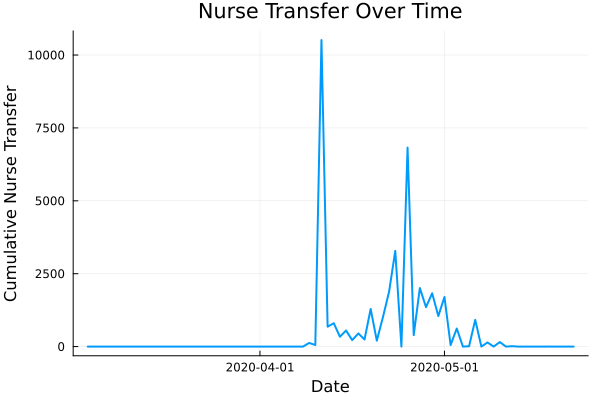

In [163]:
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 5, 22)
date_range = start_date:end_date
#gr()
plot(date_range, cumulative_sent,
     xlabel = "Date",
     ylabel = "Cumulative Nurse Transfer",
     title = "Nurse Transfer Over Time",
     legend = false,
     linewidth = 2,fmt=:png) 
#savefig(joinpath("../figures", "Overall_sent_plot_Contagion.png"))    

In [427]:
nurseTransfer = DataFrame(date = date_range, shortage = cumulative_sent)
using CSV
CSV.write("../data output/ContagNtransfer304-522.csv",nurseTransfer)

"../data output/ContagNtransfer304-522.csv"

In [494]:
describe(nurseTransfer.shortage)

Summary Stats:
Length:         80
Missing Count:  0
Mean:           625.550934
Std. Deviation: 1263.563632
Minimum:        0.000000
1st Quartile:   0.000000
Median:         33.803094
3rd Quartile:   634.071064
Maximum:        6955.475556
Type:           Float64


patient transfer

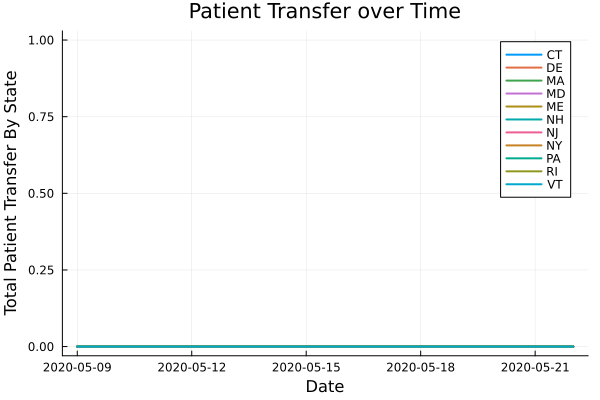

In [428]:
start_date = Date(2020, 5, 9)
end_date   = Date(2020, 5, 22)
date_range = start_date:end_date
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)
df = complete_modelp

cleaned_df = DataFrame(State=df.location, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11xt matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, T)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# # check the shortage matrix
# # size(shortage_matrix)

plot(date_range,[vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Total Patient Transfer By State",
     title = "Patient Transfer over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)

#savefig(joinpath("../figures", "Contagion_NTransfer_plot224-410.png"))
